In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install transformers
#!pip install focal_loss
#!pip install focal-loss

     |████████████████████████████████| 4.9 MB 4.4 MB/s 
     |████████████████████████████████| 1.8 MB 4.6 MB/s 
     |████████████████████████████████| 116 kB 52.1 MB/s 
     |████████████████████████████████| 352 kB 52.7 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
     |████████████████████████████████| 99 kB 10.4 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 
     |████████████████████████████████| 238 kB 49.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 15.0 MB/s 
     |████████████████████████████████| 6.6 MB 39.8 MB/s 


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import sklearn
from sklearn.utils import shuffle

#from focal_loss import SparseCategoricalFocalLoss
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import keras
tf.get_logger().setLevel('ERROR')

#from nltk.corpus import stopwords  
#from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer
#from string import punctuation
#from collections import Counter 
#import wordcloud
#from nltk.corpus import stopwords 
#from textblob import Word 
#import re
#import nltk

In [3]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')

In [4]:
original_train_data = pd.read_csv("/content/original_train_data.csv")

In [5]:
original_train_data = original_train_data[['sentence','maslow']]
original_train_data['maslow'] = original_train_data['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])

In [6]:
original_train_data.head(2)

,sentence,maslow
0,Melissa never drank wine.Melissa broke up with...,basic_needs
1,Ray couldn't get an irritating tune out of his...,none


In [7]:
original_train_data['maslow'] = original_train_data['maslow'].replace(['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs','none'],['need','need','need','need','need','no need'])

In [8]:
original_train_data.head(2)

,sentence,maslow
0,Melissa never drank wine.Melissa broke up with...,need
1,Ray couldn't get an irritating tune out of his...,no need


In [9]:
lb = LabelEncoder() 
original_train_data['maslowLabel'] = lb.fit_transform(original_train_data['maslow'])
print(original_train_data['maslow'].unique())
print(original_train_data['maslowLabel'].unique())

['need' 'no need']
[0 1]


In [10]:
original_train_data.head(2)

,sentence,maslow,maslowLabel
0,Melissa never drank wine.Melissa broke up with...,need,0
1,Ray couldn't get an irritating tune out of his...,no need,1


In [11]:
original_train_data[['sentence','maslow']].groupby('maslow').count()

,sentence
maslow,
need,14440
no need,2034


In [12]:
#x_train, x_test, y_train, y_test = train_test_split(df2oftype2['sentence'],df2oftype2['maslowLabel'],test_size = 0.2, random_state = 0, stratify = df2oftype2['maslowLabel'])
x_train_text = original_train_data['sentence']
y_train_text = original_train_data['maslow']
x_train = original_train_data['sentence']
y_train = original_train_data['maslowLabel']
print(x_train.shape)
#print(x_val.shape)

(16474,)


In [13]:
unique, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[[    0 14440]
 [    1  2034]]


In [14]:
y_train = tf.keras.utils.to_categorical(y_train)
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_encoder = map_name_to_handle[bert_model_name]
bert_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {bert_encoder}')
print(f'Preprocess model auto-selected: {bert_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1")

In [18]:
#!pip install keras-tuner --upgrade
#import keras_tuner

In [19]:
def focal_loss(gamma=2., alpha=4.):   

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalCrossentropy(name='categorical_cross_entropy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      'accuracy'
]

In [20]:
# Note the training variable in the Batch Normalization function. This is required because Batch Normalization operates differently during training vs. the application stage– during training the z score is computed using the batch mean and variance, while in inference, it’s computed using a mean and variance estimated from the entire training set.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.6, name="dropout1")(outputs['pooled_output'])
l = tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_uniform',name = 'layer1')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.5, name="dropout2")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer2')(l)
l = tf.keras.layers.BatchNormalization()(l, training= True)

l = tf.keras.layers.Dropout(0.6, name="dropout3")(l)
l = tf.keras.layers.Dense(units = 128, activation = None, kernel_initializer = 'he_uniform',name = 'layer3')(l)
l = tf.keras.layers.Dense(2, activation='softmax', name="output")(l)
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.compile(loss= focal_loss(alpha=0.1, gamma = 2) , optimizer='adam', metrics=METRICS)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

#### Test Set

In [22]:
original_test_data = pd.read_csv("/content/original_test_data.csv")
annotated_noneedcat_test_data_1 = pd.read_excel("/content/test_data_noneed_with_predictions_set_1.xlsx")
annotated_noneedcat_test_data_2 = pd.read_excel('/content/test_data_noneed_with_predictions_set_2.xlsx')
annotated_noneedcat_test_data_3 = pd.read_excel('/content/test_data_noneed_with_predictions_set_3.xlsx')
annotated_noneedcat_test_data_4 = pd.read_excel('/content/test_data_noneed_with_predictions_set_4.xlsx')
annotated_noneedcat_test_data = pd.concat([annotated_noneedcat_test_data_1,annotated_noneedcat_test_data_2,annotated_noneedcat_test_data_3,annotated_noneedcat_test_data_4])
annotated_noneedcat_test_data = shuffle(annotated_noneedcat_test_data)
annotated_noneedcat_test_data['our'] = annotated_noneedcat_test_data['our'].replace([1,0],['no need','need'])
annotated_noneedcat_test_data = annotated_noneedcat_test_data[['sentence','our','annotator']]
annotated_noneedcat_test_data.rename(columns = {'our':'maslow'},inplace = True)
annotated_noneedcat_test_data.head(2)

,sentence,maslow,annotator
70,Donnie is working at his job.He is cutting woo...,need,ajinkya
96,Mary had been feeling depressed lately.She dec...,need,gurudeep


In [29]:
original_test_data = original_test_data[['sentence','maslow']]
original_test_data['maslow'] = original_test_data['maslow'].replace(['physiological','love','stability','esteem','spiritual growth'],['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs'])
original_test_data['maslow'] = original_test_data['maslow'].replace(['basic_needs','basic_needs','basic_needs','advanced_needs','advanced_needs','none'],['need','need','need','need','need','no need'])
original_test_data = original_test_data[original_test_data['maslow']!='no need']
original_test_data['annotator'] = 'na'
original_test_data = pd.concat([original_test_data,annotated_noneedcat_test_data])
original_test_data = shuffle(original_test_data)
original_test_data[['sentence','maslow','annotator']].groupby(['maslow','annotator']).count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


sentence
maslow  annotator          
need    ajinkya          95
        anish            94
        gurudeep         58
        na             3862
        vivek             5
no need ajinkya          32
        anish            33
        gurudeep         68
        vivek           122

In [30]:
original_test_data[['sentence','maslow']].groupby(['maslow']).count()

,sentence
maslow,
need,4114
no need,255


In [31]:
original_test_data['maslowLabel'] = lb.fit_transform(original_test_data['maslow'])
print(original_test_data['maslow'].unique())
print(original_test_data['maslowLabel'].unique())

['need' 'no need']
[0 1]


In [32]:
x_test_text = original_test_data['sentence']
y_test_text = original_test_data['maslow']
x_test = original_test_data['sentence']
y_test = original_test_data['maslowLabel']
print(x_test.shape)

(4369,)


In [33]:
unique, counts = np.unique(y_test, return_counts=True)
result = np.column_stack((unique, counts)) 
print (result)

[[   0 4114]
 [   1  255]]


In [34]:
y_test =  tf.keras.utils.to_categorical(y_test)

#### Training

In [35]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 1,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')          # Reduce learning rate when a metric has stopped improving.

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
# compile model
model.compile(loss= focal_loss(alpha=0.1, gamma = 2) , optimizer='adam', metrics=METRICS)
history = model.fit(x_train, y_train,epochs=20, verbose=1, validation_data = (x_test,y_test), batch_size  = 8,callbacks=[model_checkpoint_callback,callback, reduce_lr])

Epoch 1/20
2060/2060 [==============================] - 109s 48ms/step - loss: 0.0193 - tp: 13167.0000 - fp: 3307.0000 - tn: 13167.0000 - fn: 3307.0000 - categorical_cross_entropy: 0.5163 - precision: 0.7993 - recall: 0.7993 - auc: 0.8388 - prc: 0.8047 - accuracy: 0.7993 - val_loss: 0.0070 - val_tp: 4106.0000 - val_fp: 263.0000 - val_tn: 4106.0000 - val_fn: 263.0000 - val_categorical_cross_entropy: 0.4258 - val_precision: 0.9398 - val_recall: 0.9398 - val_auc: 0.9546 - val_prc: 0.9440 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 2/20
2060/2060 [==============================] - ETA: 0s - loss: 0.0116 - tp: 14042.0000 - fp: 2432.0000 - tn: 14042.0000 - fn: 2432.0000 - categorical_cross_entropy: 0.4804 - precision: 0.8524 - recall: 0.8524 - auc: 0.8802 - prc: 0.8560 - accuracy: 0.8524
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2060/2060 [==============================] - 98s 47ms/step - loss: 0.0116 - tp: 14042.0000 - fp: 2432.0000 - tn: 14042.0000 - fn: 24

In [36]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)
# 0.1,0.1,0.01

137/137 [==============================] - 19s 139ms/step - loss: 0.0067 - tp: 4107.0000 - fp: 262.0000 - tn: 4107.0000 - fn: 262.0000 - categorical_cross_entropy: 0.4201 - precision: 0.9400 - recall: 0.9400 - auc: 0.9633 - prc: 0.9588 - accuracy: 0.9400


[0.006650099065154791,
 4107.0,
 262.0,
 4107.0,
 262.0,
 0.4201087951660156,
 0.9400320649147034,
 0.9400320649147034,
 0.9633466601371765,
 0.9587632417678833,
 0.9400320649147034]

In [37]:
print(history.history.keys())

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'categorical_cross_entropy', 'precision', 'recall', 'auc', 'prc', 'accuracy', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_categorical_cross_entropy', 'val_precision', 'val_recall', 'val_auc', 'val_prc', 'val_accuracy', 'lr'])


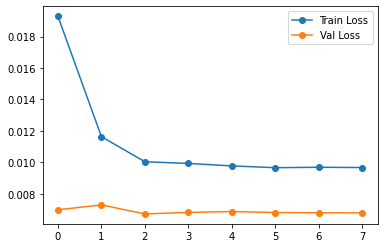

In [38]:
plt.plot(history.history['loss'], '-o', label='Train Loss')
plt.plot(history.history['val_loss'], '-o', label = 'Val Loss')
plt.legend()

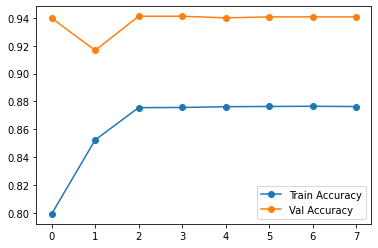

In [39]:
plt.plot(history.history['accuracy'], '-o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'Val Accuracy')
plt.legend()

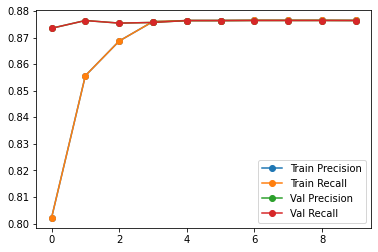

In [ ]:
plt.plot(history.history['precision'], '-o', label='Train Precision')
plt.plot(history.history['recall'], '-o', label = 'Train Recall')
plt.plot(history.history['val_precision'], '-o', label='Val Precision')
plt.plot(history.history['val_recall'], '-o', label = 'Val Recall')
plt.legend()

In [40]:
y_pred2 = model.predict(x_test)

In [41]:
y_pred2[2]

array([0.7397296 , 0.26027042], dtype=float32)

In [42]:
def get_predictions(y_pred2):
    review_predictions2 = []
    for prediction in y_pred2:
        x = prediction
        review_predictions2.append(np.argmax(x))

    review_predictions2 = np.array(review_predictions2)
    review_predictions2.reshape(1,-1)
    print(review_predictions2.shape)
    return review_predictions2

In [43]:
review_predictions2 = get_predictions(y_pred2)

(4369,)


In [44]:
review_predictions2

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
k = pd.DataFrame(review_predictions2, columns = ['Label'])
k.groupby('Label')['Label'].count()

Label
0    4358
1      11
Name: Label, dtype: int64

In [46]:
y_test_text

1364    need
3293    need
82      need
1322    need
3558    need
        ... 
1324    need
2925    need
2921    need
3103    need
165     need
Name: maslow, Length: 4369, dtype: object

In [47]:
integer_label = original_test_data['maslowLabel']

In [48]:
integer_label = integer_label.reset_index(drop = True)

In [49]:
integer_label

0       0
1       0
2       0
3       0
4       0
       ..
4364    0
4365    0
4366    0
4367    0
4368    0
Name: maslowLabel, Length: 4369, dtype: int64

In [50]:
review_predictions2[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [52]:
original_test_data.head()
uniqueClassesMaslowLabel2 = list(original_test_data['maslow'].unique())
uniqueClassesMaslow2 = list(original_test_data['maslowLabel'].unique())
uniqueClassesMaslowLabel2 = ['need','no need']
uniqueClassesMaslow2 = [0,1]
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)
print(classification_report(review_predictions2, integer_label,target_names = uniqueClassesMaslowLabel2))

['need', 'no need']
[0, 1]
              precision    recall  f1-score   support

        need       1.00      0.94      0.97      4358
     no need       0.01      0.18      0.02        11

    accuracy                           0.94      4369
   macro avg       0.50      0.56      0.49      4369
weighted avg       1.00      0.94      0.97      4369



In [53]:
review_predictions2

array([0, 0, 0, ..., 0, 0, 0])

[[4105  253]
 [   9    2]]


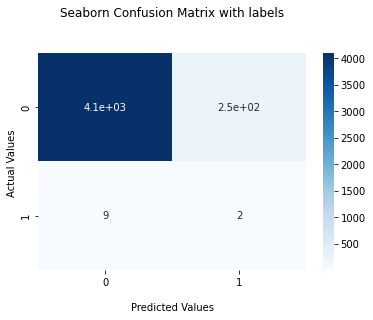

In [54]:
import seaborn as sns
r2 = sklearn.metrics.confusion_matrix(review_predictions2, integer_label)
print(r2)
ax = sns.heatmap(r2, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

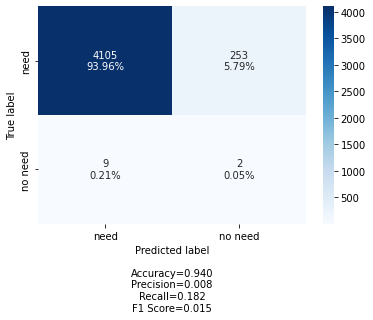

In [55]:
make_confusion_matrix(r2, group_names=uniqueClassesMaslow2, categories=uniqueClassesMaslowLabel2, cmap='Blues')

In [56]:
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)

['need', 'no need']
[0, 1]


In [57]:
x_test_text = x_test_text.reset_index(drop = True)
x_test_text[0:5]

0    Johnny loved his red and blue ball.He'd spend ...
1                   The magician pulled out a top hat.
2    Linda loved capuchin monkeys.After years of sa...
3    I bought an ocarina in 1973.I had always wante...
4    Jacob loved gorillas a lot.In fact, he liked t...
Name: sentence, dtype: object

In [58]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [59]:
print(uniqueClassesMaslowLabel2)
print(uniqueClassesMaslow2)

['need', 'no need']
[0, 1]


In [76]:
original_test_data.head(2)

,sentence,maslow,annotator,maslowLabel
1364,Johnny loved his red and blue ball.He'd spend ...,need,na,0
3293,The magician pulled out a top hat.,need,na,0


In [84]:
def get_mistakes(prediction_values, actual_values, test_sentences, actual_category, predicted_category,samples_shown):
    # Make sure you Map uniqueClassesMaslowLabell2 catgory with the labels mapping as index. If label is 0 then the category index in the list should be 0
    count = 0
    correct_index = uniqueClassesMaslowLabel2.index(actual_category)
    incorrect_index = uniqueClassesMaslowLabel2.index(predicted_category)
    print('Text classified as ',uniqueClassesMaslowLabel2[incorrect_index]," but actual category is ",uniqueClassesMaslowLabel2[correct_index])
    for i in range(0,len(prediction_values)):
        if prediction_values[i] == incorrect_index and actual_values[i] == correct_index and count != samples_shown:
            print(str(i),original_test_data.iloc[i][0])
            count = count + 1

   
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'need', 
             predicted_category = 'no need',
             samples_shown = 10)


Text classified as  no need  but actual category is  need
926 It was 2 AM.And Carl saw a spider in his room.But it got away.
1388 The man got angry.
2466 Angie liked going fast.
3405 Billy's cat got stuck in a tree.
3706 Anna saw a quarter on the ground.She bent to pick it up.But she couldn't.
3726 There was a squirrel running around outside of my apartment.
3786 Sam was riding her bike.She was going really fast down the sidewalk.A dog jumped out in front of her.
3860 Gale was walking her dog down the street.There was a cat in the sidewalk.Gale's dog saw the cat.
4341 The office was abuzz with talk of the new, blonde secretary.


In [85]:
get_mistakes(prediction_values = review_predictions2,
             actual_values = integer_label,
             test_sentences = x_test_text,
             actual_category = 'no need', 
             predicted_category = 'need',
             samples_shown = 50)

Text classified as  need  but actual category is  no need
22 John forgot he had a gig after work.
24 Joe and Jane were two candidates for a job.Joe was knowledgeable and intelligent.However, the hiring manager liked Jane's personality.The hiring manager decided to flip a coin to decide who to hire.
51 Tom was going to turn 80 years old.
61 Jessica liked tormenting her brother.She also liked to get him into trouble.
79 Kim was grocery shopping.
91 Tom liked to drink.One day, he drove when he was drunk.He drove right through a red light.He hit someone who was crossing the road.The person he hit died a few days later.
131 Tina was out for a walk in the street.All of the sudden it started to rain.Tina got caught in the rain.She didn't have an umbrella.
138 My wife collects vintage dolls.She saw a doll selling on eBay for $10.She put in a proxy bid of $25.She was outbid quickly.The doll sold for $50.
155 Ray walked home from school everyday.And he noticed that the same man had his garage op